# 0. Library Installation
Run this cell to install the required libraries for the entire homework.
* `gymnasium`: The reinforcement learning environment standard.
* `numpy`: For numerical operations and matrix handling.
* `matplotlib` & `seaborn`: For visualizing value functions and policies.
* `pygame`: Required by Gymnasium for rendering Toy Text environments like FrozenLake.

In [ ]:
%pip install gymnasium numpy matplotlib seaborn pygame

# Problem 2: FrozenLake Dynamic Programming

## 1. Setup and Helper Functions
In this section, we import the necessary libraries (`gymnasium`, `numpy`, `matplotlib`) and define helper functions to:
1.  **Create the Environment:** Uses `generate_random_map` with `seed=42` as requested.
2.  **Visualize Results:** Plots the value function as a heatmap and overlays the optimal policy using arrows ($\leftarrow, \downarrow, \rightarrow, \uparrow$).

**Action Mapping:**
* 0: Left
* 1: Down
* 2: Right
* 3: Up

In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from gymnasium.envs.toy_text.frozen_lake import generate_random_map

# Action mapping for visualization
ACTION_ARROWS = {0: "←", 1: "↓", 2: "→", 3: "↑"}


def get_env(map_name="4x4", is_slippery=False, seed=42):
    """
    Creates the FrozenLake environment. 
    Uses generate_random_map with seed 42 as requested.
    """
    if map_name == "4x4":
        size = 4
    elif map_name == "8x8":
        size = 8
    else:
        raise ValueError("Map size must be '4x4' or '8x8'")

    desc = generate_random_map(size=size, seed=seed)
    env = gym.make("FrozenLake-v1", desc=desc,
                   is_slippery=is_slippery, render_mode="rgb_array")
    return env


def plot_policy_value(V, policy, env, title="Value Function & Policy"):
    """
    Plots the value function heatmap and overlays the policy arrows.
    Satisfies requirements for visualising V(s) and Policy arrows.
    """
    rows = env.unwrapped.desc.shape[0]
    cols = env.unwrapped.desc.shape[1]

    # Reshape value function for plotting
    V_grid = V.reshape((rows, cols))

    plt.figure(figsize=(8, 6))
    sns.heatmap(V_grid, annot=False, fmt=".2f",
                cmap="YlGnBu", cbar_kws={'label': 'Value'})

    # Overlay Arrows and Text
    for r in range(rows):
        for c in range(cols):
            state_idx = r * cols + c

            # Check for terminal states (Hole or Goal)
            cell_type = env.unwrapped.desc[r, c].decode('utf-8')

            if cell_type == 'H':  # Hole
                plt.text(c + 0.5, r + 0.5, "HOLE", color="red",
                         ha="center", va="center", weight="bold", fontsize=8)
            elif cell_type == 'G':  # Goal
                plt.text(c + 0.5, r + 0.5, "GOAL", color="green",
                         ha="center", va="center", weight="bold", fontsize=8)
            else:
                # Plot Value (small text)
                plt.text(c + 0.5, r + 0.2, f"{V_grid[r, c]:.2f}",
                         color="black", ha="center", va="center", fontsize=8)

                # Plot Policy Arrow (large text)
                action = policy[state_idx]
                plt.text(c + 0.5, r + 0.6, ACTION_ARROWS[action],
                         color="black", ha="center", va="center", fontsize=16, weight="bold")

    plt.title(title)
    plt.axis("off")
    plt.show()


def evaluate_agent(env, policy, episodes=100, gamma=0.9):
    """
    Executes the agent using the optimal policy.
    Returns the average discounted reward.
    """
    total_rewards = []

    for _ in range(episodes):
        state, _ = env.reset()
        episode_reward = 0
        step = 0
        terminated = False
        truncated = False

        while not (terminated or truncated):
            action = policy[state]
            state, reward, terminated, truncated, _ = env.step(action)
            episode_reward += (gamma ** step) * reward
            step += 1

        total_rewards.append(episode_reward)

    return np.mean(total_rewards)

## 2. Algorithm Implementation: Policy Iteration & Value Iteration

Here we implement the core Dynamic Programming algorithms:

1.  **Policy Iteration:**
    * **Policy Evaluation:** Iteratively solves the Bellman Expectation Equation until $\Delta < \theta$.
    * **Policy Improvement:** Updates the policy to be greedy with respect to the current value function.
2.  **Value Iteration:**
    * Combines estimation and improvement using the Bellman Optimality Equation.
    * Stops when the maximum change in value function $\Delta < \theta$.

**Parameters:**
* $\gamma = 0.9$
* $\theta = 10^{-3}$

In [2]:
def policy_evaluation(policy, env, gamma=0.9, theta=1e-3):
    """
    Computes V for a given policy until convergence.
    """
    n_states = env.observation_space.n
    V = np.zeros(n_states)
    steps = 0

    while True:
        delta = 0
        for s in range(n_states):
            v_old = V[s]
            a = policy[s]
            v_new = 0
            # Sum over transitions: P(s'|s,a)
            for prob, next_state, reward, terminated in env.unwrapped.P[s][a]:
                v_new += prob * (reward + gamma *
                                 V[next_state] * (not terminated))

            V[s] = v_new
            delta = max(delta, abs(v_old - V[s]))

        steps += 1
        if delta < theta:
            break

    return V, steps


def policy_improvement(V, env, gamma=0.9):
    """
    Returns a greedy policy based on V.
    """
    n_states = env.observation_space.n
    n_actions = env.action_space.n
    policy = np.zeros(n_states, dtype=int)

    for s in range(n_states):
        action_values = np.zeros(n_actions)
        for a in range(n_actions):
            for prob, next_state, reward, terminated in env.unwrapped.P[s][a]:
                action_values[a] += prob * \
                    (reward + gamma * V[next_state] * (not terminated))
        policy[s] = np.argmax(action_values)

    return policy


def run_policy_iteration(env, gamma=0.9, theta=1e-3):
    """
    Executes Policy Iteration. 
    Returns: policy, V, metrics dictionary
    """
    start_time = time.time()
    n_states = env.observation_space.n
    policy = np.random.choice(env.action_space.n, size=n_states)  # Random init

    total_eval_steps = 0
    improv_steps = 0

    while True:
        # 1. Evaluate
        V, eval_steps = policy_evaluation(policy, env, gamma, theta)
        total_eval_steps += eval_steps

        # 2. Improve
        new_policy = policy_improvement(V, env, gamma)
        improv_steps += 1

        # Check stability
        if np.array_equal(new_policy, policy):
            break
        policy = new_policy

    execution_time = time.time() - start_time

    # Correction: ensure variable name matches 'improv_steps' defined above
    return policy, V, {"time": execution_time, "improv_steps": improv_steps, "eval_steps": total_eval_steps}


def run_value_iteration(env, gamma=0.9, theta=1e-3):
    """
    Executes Value Iteration.
    Returns: policy, V, metrics dictionary
    """
    start_time = time.time()
    n_states = env.observation_space.n
    n_actions = env.action_space.n
    V = np.zeros(n_states)
    iterations = 0

    while True:
        delta = 0
        for s in range(n_states):
            v_old = V[s]
            action_values = np.zeros(n_actions)
            for a in range(n_actions):
                for prob, next_state, reward, terminated in env.unwrapped.P[s][a]:
                    action_values[a] += prob * \
                        (reward + gamma * V[next_state] * (not terminated))

            V[s] = np.max(action_values)
            delta = max(delta, abs(v_old - V[s]))

        iterations += 1
        if delta < theta:
            break

    # Extract Policy
    policy = policy_improvement(V, env, gamma)

    execution_time = time.time() - start_time
    return policy, V, {"time": execution_time, "iterations": iterations}

## Part A: Deterministic Maps (4x4 & 8x8)

In this part, we solve the **Deterministic** FrozenLake environments.

**Tasks:**
1.  **Policy Iteration:** Run on both maps, record time, and improvement/evaluation steps.
2.  **Value Iteration:** Run on both maps, record time and iterations.
3.  **Visualization:** Plot $V(s)$ and overlay the optimal policy arrows.
4.  **Comparison:** Compare execution speed and resulting value functions.
5.  **Agent Check:** Verify the calculated $V(Start)$ against an empirical agent run.

PART A: DETERMINISTIC MAPS

--- Processing Deterministic 4x4 Map ---
[Policy Iteration] Time: 0.00976s | Improv Steps: 7 | Eval Steps: 28


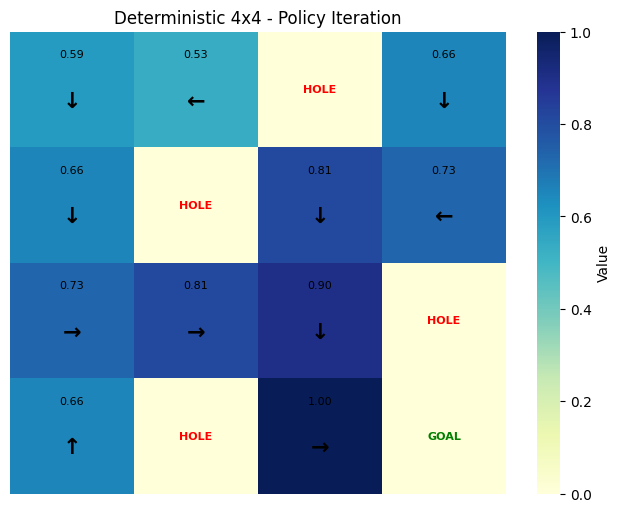

[Value Iteration]  Time: 0.00505s | Iterations: 7


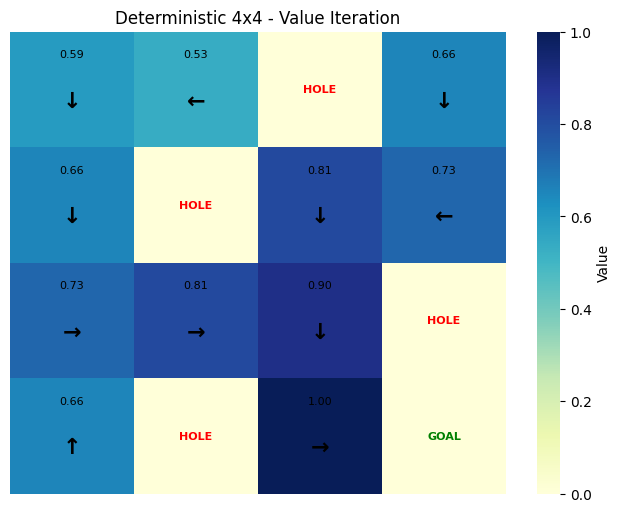

Max Value Difference (PI vs VI): 0.00000
>> Faster Algorithm: Value Iteration
Agent Execution Reward: 0.5905 vs Calculated V(Start): 0.5905

--- Processing Deterministic 8x8 Map ---
[Policy Iteration] Time: 0.06831s | Improv Steps: 14 | Eval Steps: 119


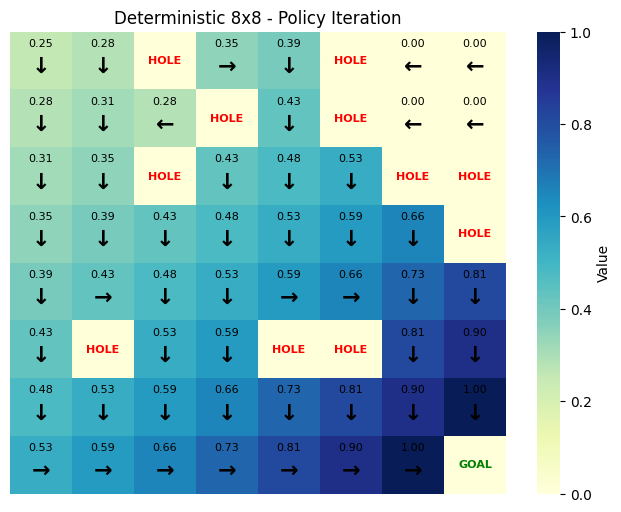

[Value Iteration]  Time: 0.04305s | Iterations: 15


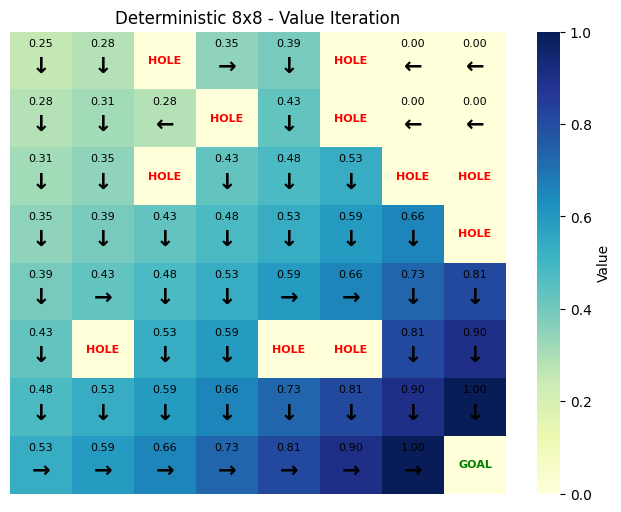

Max Value Difference (PI vs VI): 0.00000
>> Faster Algorithm: Value Iteration
Agent Execution Reward: 0.2542 vs Calculated V(Start): 0.2542


In [3]:
maps_to_run = ["4x4", "8x8"]
GAMMA = 0.9
THETA = 1e-3

print("="*60)
print("PART A: DETERMINISTIC MAPS")
print("="*60)

for map_size in maps_to_run:
    print(f"\n--- Processing Deterministic {map_size} Map ---")
    env = get_env(map_name=map_size, is_slippery=False, seed=42)

    # 1. Policy Iteration (Part A: a, b, c)
    pi_policy, pi_v, pi_metrics = run_policy_iteration(env, GAMMA, THETA)
    print(
        f"[Policy Iteration] Time: {pi_metrics['time']:.5f}s | Improv Steps: {pi_metrics['improv_steps']} | Eval Steps: {pi_metrics['eval_steps']}")

    # Plot PI Results
    plot_policy_value(pi_v, pi_policy, env,
                      title=f"Deterministic {map_size} - Policy Iteration")

    # 2. Value Iteration (Part A: d, e, f)
    vi_policy, vi_v, vi_metrics = run_value_iteration(env, GAMMA, THETA)
    print(
        f"[Value Iteration]  Time: {vi_metrics['time']:.5f}s | Iterations: {vi_metrics['iterations']}")

    # Plot VI Results
    plot_policy_value(vi_v, vi_policy, env,
                      title=f"Deterministic {map_size} - Value Iteration")

    # 3. Comparison (Part A: g, h)
    diff = np.max(np.abs(pi_v - vi_v))
    print(f"Max Value Difference (PI vs VI): {diff:.5f}")
    if pi_metrics['time'] < vi_metrics['time']:
        print(">> Faster Algorithm: Policy Iteration")
    else:
        print(">> Faster Algorithm: Value Iteration")

    # 4. Agent Execution (Part A: i)
    # Run agent 1 time (deterministic) to check V(Start)
    avg_reward = evaluate_agent(env, vi_policy, episodes=1, gamma=GAMMA)
    print(
        f"Agent Execution Reward: {avg_reward:.4f} vs Calculated V(Start): {vi_v[0]:.4f}")

## Part B: Stochastic Maps (4x4 & 8x8)

In this part, we solve the **Stochastic** FrozenLake environments.

**Tasks:**
1.  **Value Iteration:** Solve for the optimal value function using VI.
2.  **Visualization:** Plot the heatmap and policy arrows.
3.  **Policy Difference:** Compare the policy to the deterministic version (visually).
4.  **Agent Check:** Run the agent 100 times to average the return and compare it to $V(Start)$.


PART B: STOCHASTIC MAPS (Value Iteration Only)

--- Processing Stochastic 4x4 Map ---
[Value Iteration] Time: 0.01062s | Iterations: 17


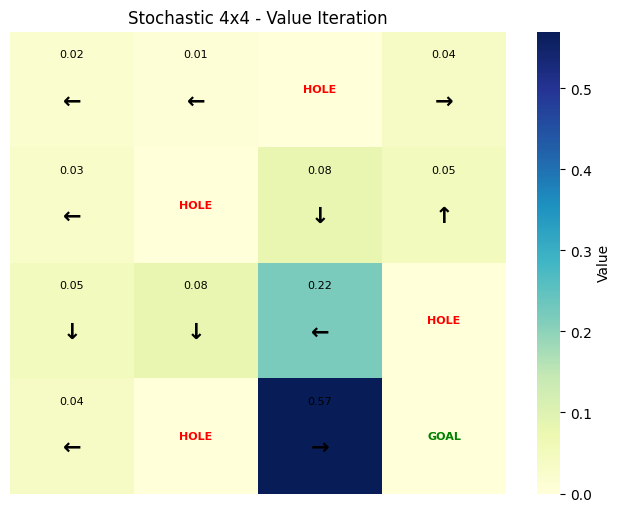

Stochastic Evaluation (4x4):
  > Calculated V(Start): 0.0201
  > Avg Empirical Reward (100 runs): 0.0193
  > Difference: 0.0008

--- Processing Stochastic 8x8 Map ---
[Value Iteration] Time: 0.06390s | Iterations: 26


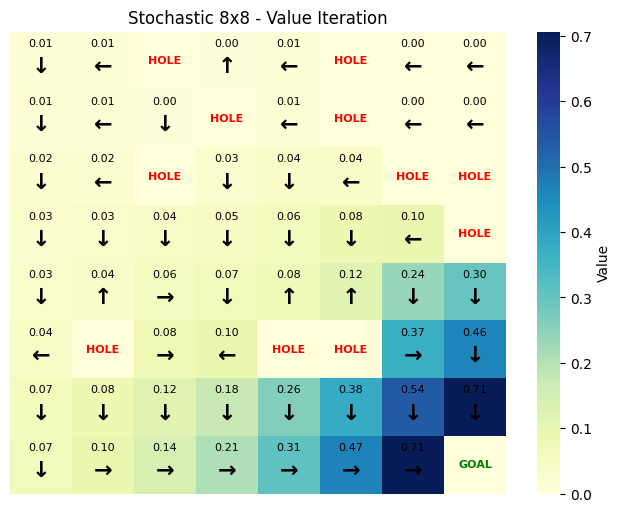

Stochastic Evaluation (8x8):
  > Calculated V(Start): 0.0063
  > Avg Empirical Reward (100 runs): 0.0105
  > Difference: 0.0042


In [4]:
print("\n" + "="*60)
print("PART B: STOCHASTIC MAPS (Value Iteration Only)")
print("="*60)

for map_size in maps_to_run:
    print(f"\n--- Processing Stochastic {map_size} Map ---")

    # Setup Stochastic Env (is_slippery=True)
    env = get_env(map_name=map_size, is_slippery=True, seed=42)

    # 1. Run Value Iteration (Part B: a)
    vi_policy, vi_v, vi_metrics = run_value_iteration(env, GAMMA, THETA)
    print(
        f"[Value Iteration] Time: {vi_metrics['time']:.5f}s | Iterations: {vi_metrics['iterations']}")

    # 2. Plotting (Part B: b, c)
    plot_policy_value(vi_v, vi_policy, env,
                      title=f"Stochastic {map_size} - Value Iteration")

    # 3. Agent Evaluation (Part B: e)
    # Run 100 times to average out stochasticity
    avg_reward = evaluate_agent(env, vi_policy, episodes=100, gamma=GAMMA)
    print(f"Stochastic Evaluation ({map_size}):")
    print(f"  > Calculated V(Start): {vi_v[0]:.4f}")
    print(f"  > Avg Empirical Reward (100 runs): {avg_reward:.4f}")
    print(f"  > Difference: {abs(vi_v[0] - avg_reward):.4f}")

## Part C: Modified Reward Schedule

We modify the **Stochastic 8x8** environment to have a penalty for stepping on frozen tiles.

**Changes:**
* **Frozen Tile:** -1 Reward (was 0)
* **Hole:** 0 Reward
* **Goal:** +1 Reward

**Tasks:**
1.  Modify the environment's probability table `P`.
2.  Run Value Iteration and visualize the new policy.
3.  Compare the policy to the standard stochastic 8x8 map (Part B) to see if the agent becomes more risk-averse or takes shorter paths.


PART C: MODIFIED REWARD SCHEDULE (Stochastic 8x8)
Running Value Iteration on Modified Environment...
[Modified VI] Time: 0.06052s | Iterations: 19


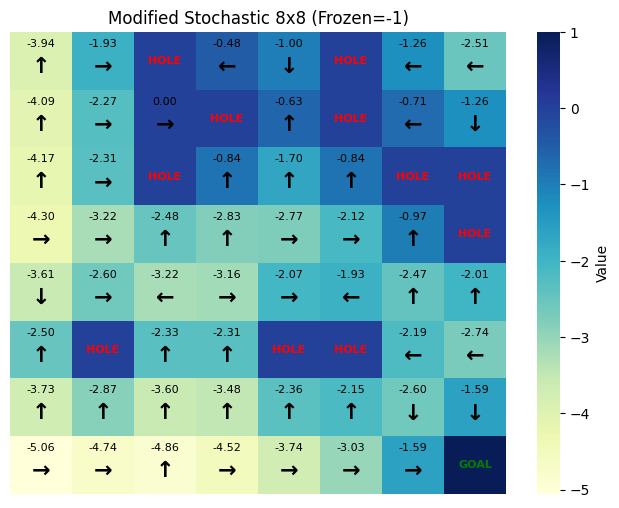

In [5]:
print("\n" + "="*60)
print("PART C: MODIFIED REWARD SCHEDULE (Stochastic 8x8)")
print("="*60)

# 1. Setup Environment
env = get_env(map_name="8x8", is_slippery=True, seed=42)

# 2. Modify Rewards (Part C: Setup)
# Iterate through the transition table P and change rewards
n_states = env.observation_space.n
n_actions = env.action_space.n
desc = env.unwrapped.desc

for s in range(n_states):
    for a in range(n_actions):
        transitions = env.unwrapped.P[s][a]
        new_transitions = []
        for prob, next_state, reward, terminated in transitions:

            # Determine tile type of NEXT state
            ns_row, ns_col = next_state // 8, next_state % 8
            ns_type = desc[ns_row, ns_col].decode('utf-8')

            new_reward = reward

            # Apply Part C rules: Frozen gives -1
            if ns_type in ['F', 'S']:
                new_reward = -1.0
            elif ns_type == 'H':
                new_reward = 0.0
            elif ns_type == 'G':
                new_reward = 1.0

            new_transitions.append((prob, next_state, new_reward, terminated))

        env.unwrapped.P[s][a] = new_transitions

# 3. Run Value Iteration (Part C: a)
print("Running Value Iteration on Modified Environment...")
mod_policy, mod_v, mod_metrics = run_value_iteration(env, GAMMA, THETA)

print(
    f"[Modified VI] Time: {mod_metrics['time']:.5f}s | Iterations: {mod_metrics['iterations']}")

# 4. Plot (Part C: a, b)
plot_policy_value(mod_v, mod_policy, env,
                  title="Modified Stochastic 8x8 (Frozen=-1)")

# Problem 3: Custom Server Queue Environment

In this problem, we implement a custom environment compatible with the Gymnasium API. The environment simulates a server managing three queues.

## Environment Specifications

### 1. State Space (Observation Space)
The state is represented by a `MultiDiscrete` space with 4 dimensions: `[Q1, Q2, Q3, Pos]`.
* **Q1, Q2, Q3:** Number of items in each queue. Capacity is 5 items per queue (Values 0–5).
* **Pos:** The server's current location (0=Queue 1, 1=Queue 2, 2=Queue 3).
* **Gym Space:** `spaces.MultiDiscrete([6, 6, 6, 3])`

### 2. Action Space
There are 4 discrete actions:
* **0 (Service):** Service an item from the current queue.
* **1 (Switch Q1):** Move server to Queue 1.
* **2 (Switch Q2):** Move server to Queue 2.
* **3 (Switch Q3):** Move server to Queue 3.

### 3. Dynamics & Rewards
* **Service Action:**
    * If the current queue has items ($>0$): Decrement count, Reward = **+1**.
    * If empty: No change, Reward = **0**.
* **Switch Action:** Moves the server to the target queue. Reward = **0**.
* **Arrival Process:** *After* the action is taken, each queue $i$ independently receives a new item with probability $P_i$ (provided the queue is not full).

### 4. Configurations
We verify the implementation with two probability sets:
1.  **Set A:** $P = [0.1, 0.9, 0.1]$
2.  **Set B:** $P = [0.1, 0.1, 0.1]$

In [6]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np


class ServerQueueEnv(gym.Env):
    """
    Custom Environment for Problem 3: Server with 3 Queues.
    Inherits from gymnasium.Env.
    """

    def __init__(self, arrival_probs=[0.1, 0.9, 0.1]):
        super(ServerQueueEnv, self).__init__()

        # arrival_probs: [P1, P2, P3]
        self.arrival_probs = arrival_probs

        # Action Space: 4 actions
        # 0: Service current
        # 1: Switch to Q1
        # 2: Switch to Q2
        # 3: Switch to Q3
        self.action_space = spaces.Discrete(4)

        # Observation Space:
        # Indices 0-2: Items in Q1, Q2, Q3. Max capacity 5 -> 6 possible values (0-5).
        # Index 3: Server Position. 3 possible values (0, 1, 2).
        self.observation_space = spaces.MultiDiscrete([6, 6, 6, 3])

        self.state = None

    def reset(self, seed=None, options=None):
        """
        Resets the environment to the initial state.
        Server starts at Queue 1 (Index 0). Queues start empty.
        """
        super().reset(seed=seed)

        self.state = np.array([0, 0, 0, 0], dtype=np.int32)

        return self.state, {}

    def step(self, action):
        """
        Executes one time step within the environment.
        """
        q1, q2, q3, pos = self.state
        queues = [q1, q2, q3]
        reward = 0

        # --- Phase 1: Server Action ---
        if action == 0:  # Service
            if queues[pos] > 0:
                queues[pos] -= 1
                reward = 1
            else:
                reward = 0  # Empty queue, no reward

        elif action == 1:  # Switch to Q1
            pos = 0
        elif action == 2:  # Switch to Q2
            pos = 1
        elif action == 3:  # Switch to Q3
            pos = 2
        else:
            raise ValueError(f"Invalid action {action}")

        # --- Phase 2: Arrival Process ---
        # "After each action each queue has a probability of receiving a new item"
        for i in range(3):
            # Check if queue is not full (< 5)
            if queues[i] < 5:
                # Independent probability check
                if self.np_random.random() < self.arrival_probs[i]:
                    queues[i] += 1

        # Update internal state
        self.state = np.array(
            [queues[0], queues[1], queues[2], pos], dtype=np.int32)

        # Termination: Infinite horizon problem, so terminated is False.
        terminated = False
        truncated = False

        return self.state, reward, terminated, truncated, {}

    def render(self):
        q1, q2, q3, pos = self.state
        print(f"Server at Q{pos+1} | Q1: {q1} | Q2: {q2} | Q3: {q3}")


# --- Verification Block ---
print("="*50)
print("Problem 3: Custom Environment Verification")
print("="*50)

# 1. Test Configuration A: [0.1, 0.9, 0.1]
print("\n--- Testing Config A (High traffic on Q2) ---")
env_a = ServerQueueEnv(arrival_probs=[0.1, 0.9, 0.1])
obs, _ = env_a.reset(seed=42)
print(f"Initial State: {obs}")

print("Running 10 Random Steps:")
for i in range(10):
    action = env_a.action_space.sample()
    obs, reward, _, _, _ = env_a.step(action)
    print(f" Step {i+1}: Action={action}, Reward={reward}, State={obs}")

# 2. Test Configuration B: [0.1, 0.1, 0.1]
print("\n--- Testing Config B (Low traffic) ---")
env_b = ServerQueueEnv(arrival_probs=[0.1, 0.1, 0.1])
obs, _ = env_b.reset(seed=42)
print(f"Initial State: {obs}")

Problem 3: Custom Environment Verification

--- Testing Config A (High traffic on Q2) ---
Initial State: [0 0 0 0]
Running 10 Random Steps:
 Step 1: Action=1, Reward=0, State=[0 1 0 0]
 Step 2: Action=1, Reward=0, State=[0 2 0 0]
 Step 3: Action=3, Reward=0, State=[0 3 0 2]
 Step 4: Action=2, Reward=0, State=[0 4 0 1]
 Step 5: Action=3, Reward=0, State=[0 5 0 2]
 Step 6: Action=1, Reward=0, State=[0 5 0 0]
 Step 7: Action=0, Reward=0, State=[1 5 0 0]
 Step 8: Action=0, Reward=1, State=[0 5 0 0]
 Step 9: Action=1, Reward=0, State=[0 5 0 0]
 Step 10: Action=1, Reward=0, State=[0 5 0 0]

--- Testing Config B (Low traffic) ---
Initial State: [0 0 0 0]


# Problem 4: Monte Carlo Control (Blackjack)

## 1. Setup and Helper Functions
We use the `Blackjack-v1` environment with `sab=True` (Sutton and Barto rules).

**Helper Functions:**
1.  `plot_blackjack_results`: Generates the required 2x2 grid of plots (Usable Ace / No Usable Ace). It overlays the policy ("H" for Hit, "S" for Stick) on the Value Function heatmap.
2.  `evaluate_policy`: Runs the learned greedy policy for 100,000 episodes to calculate the empirical win/loss rates.

In [9]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import time

# --- Visualization Helper ---


def plot_blackjack_results(Q, algorithm_name="MC", epsilon=0.1):
    """
    Plots the Value Function and Policy for Usable Ace and No Usable Ace.
    """
    player_range = range(12, 22)  # Rows: Player sum 12-21
    dealer_range = range(1, 11)  # Cols: Dealer showing 1-10

    # Grids for plotting: [Usable_Ace_Index, Player_Row, Dealer_Col]
    V_grids = np.zeros((2, 10, 10))
    Policy_grids = np.empty((2, 10, 10), dtype=object)

    for p_idx, player in enumerate(player_range):
        for d_idx, dealer in enumerate(dealer_range):
            for ace in [False, True]:
                state = (player, dealer, ace)
                ace_idx = 1 if ace else 0

                if state in Q:
                    # Value is max Q-value
                    V_grids[ace_idx, p_idx, d_idx] = np.max(Q[state])
                    # Policy is argmax Q-value (1=Hit, 0=Stick)
                    best_action = np.argmax(Q[state])
                    Policy_grids[ace_idx, p_idx,
                                 d_idx] = "H" if best_action == 1 else "S"
                else:
                    V_grids[ace_idx, p_idx, d_idx] = 0.0
                    Policy_grids[ace_idx, p_idx, d_idx] = " "

    # Plotting
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    titles = ["No Usable Ace", "Usable Ace"]

    for i in range(2):
        ax = axes[i]
        sns.heatmap(V_grids[i], annot=False, fmt=".1f", cmap="coolwarm",
                    xticklabels=dealer_range, yticklabels=player_range, ax=ax)

        # Overlay Policy Letters
        for y in range(10):
            for x in range(10):
                text = Policy_grids[i, y, x]
                ax.text(x + 0.5, y + 0.5, text,
                        ha="center", va="center", color="black", fontsize=9, weight="bold")

        ax.set_title(f"{titles[i]} ({algorithm_name}, $\epsilon$={epsilon})")
        ax.set_xlabel("Dealer Showing")
        ax.set_ylabel("Player Sum")

    plt.tight_layout()
    plt.show()

# --- Evaluation Helper ---


def evaluate_policy(env, Q, num_episodes=100000):
    """
    Evaluates the greedy policy derived from Q.
    """
    wins = 0
    losses = 0
    draws = 0
    total_return = 0

    for _ in range(num_episodes):
        state, _ = env.reset()
        terminated = False
        truncated = False

        while not (terminated or truncated):
            # Greedy Action
            action = np.argmax(Q[state]) if state in Q else 0
            state, reward, terminated, truncated, _ = env.step(action)

            if terminated or truncated:
                total_return += reward
                if reward > 0:
                    wins += 1
                elif reward < 0:
                    losses += 1
                else:
                    draws += 1

    return total_return / num_episodes, wins/num_episodes, losses/num_episodes, draws/num_episodes

# Part A: Incremental Soft On-Policy Monte Carlo Control

## Algorithm
We implement **First-Visit Monte Carlo Control** using an $\epsilon$-soft policy.
* **Update Rule:** $Q(S, A) \leftarrow Q(S, A) + \frac{1}{N(S, A)} (G - Q(S, A))$
* **Diagnostics:** We record the running average return every 1,000 episodes to visualize convergence.

## Execution
We run the algorithm for $\epsilon=0.1$ and $\epsilon=0.01$.

PART A: ON-POLICY MC CONTROL

--- Running On-Policy MC (epsilon=0.1) ---


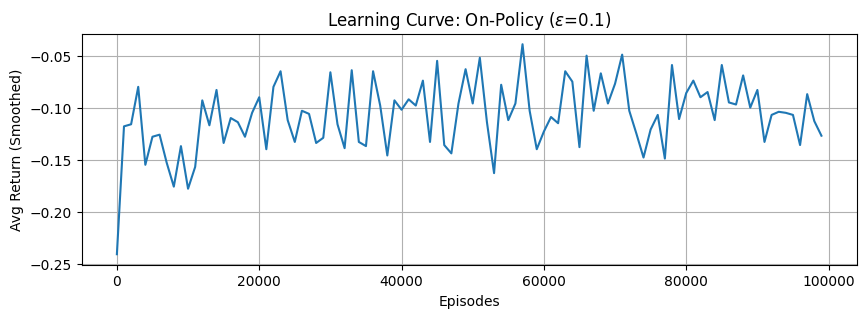

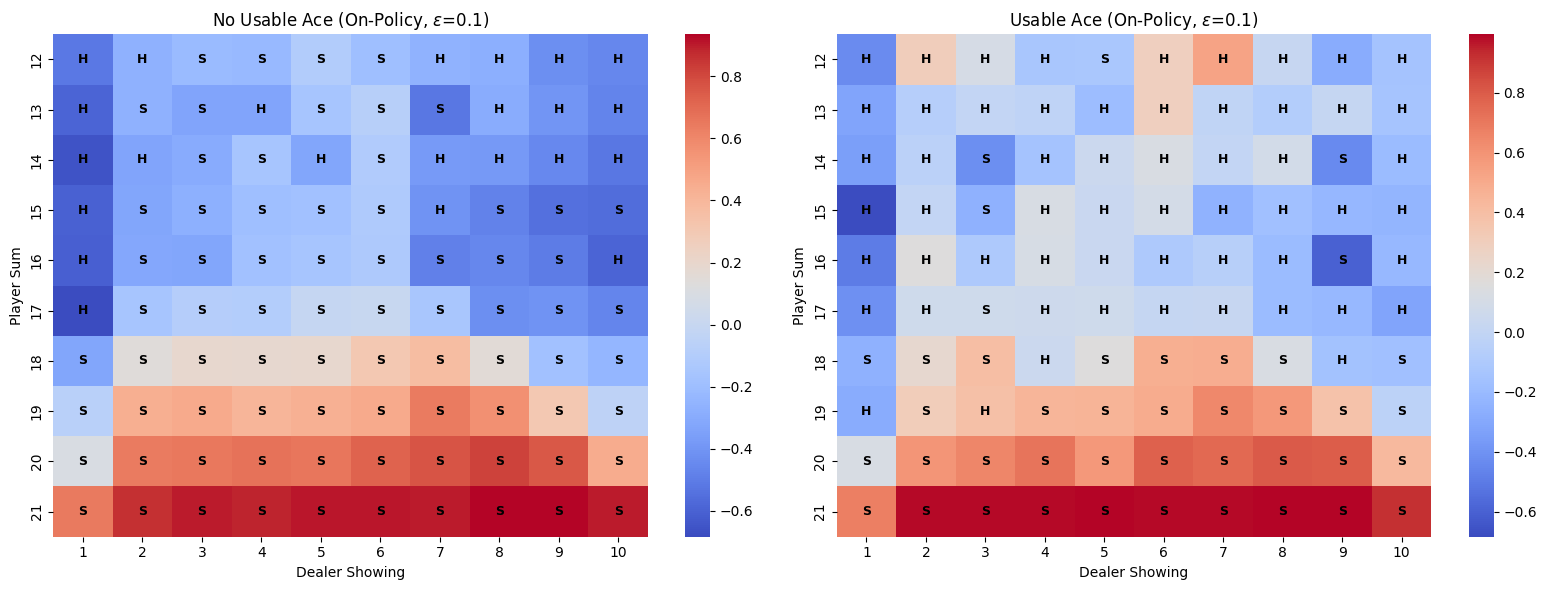

  > Runtime: 72.49s
  > Eval Return: -0.06226
  > Win: 42.7%, Loss: 49.0%, Draw: 8.3%

--- Running On-Policy MC (epsilon=0.01) ---


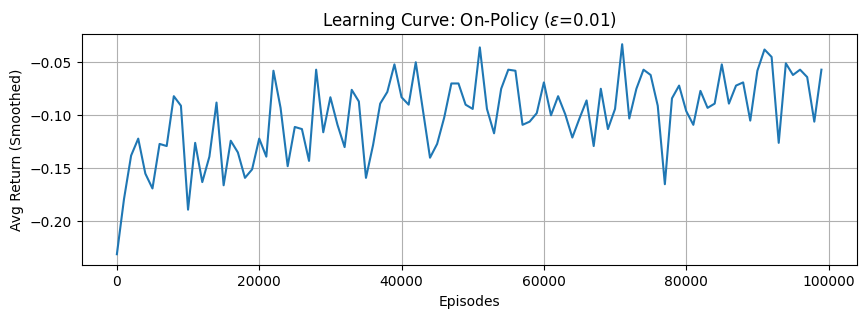

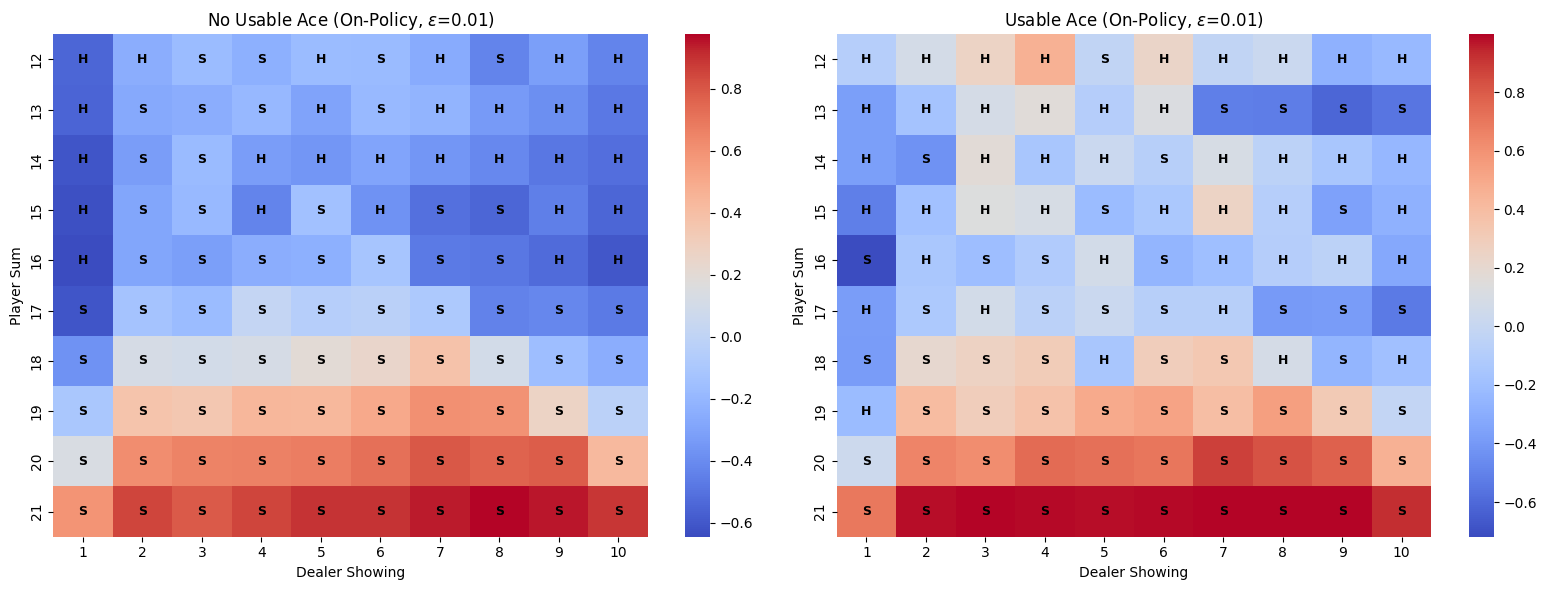

  > Runtime: 63.86s
  > Eval Return: -0.07890
  > Win: 41.8%, Loss: 49.7%, Draw: 8.6%


In [10]:
def get_epsilon_greedy_action(Q, state, epsilon, env):
    # Epsilon-soft policy
    if np.random.random() < epsilon:
        return env.action_space.sample()
    else:
        # Greedy tie-breaking: break ties randomly
        values = Q[state]
        max_val = np.max(values)
        best_actions = [a for a, v in enumerate(values) if v == max_val]
        return np.random.choice(best_actions)


def on_policy_mc_control(env, num_episodes=100000, epsilon=0.1, gamma=1.0):
    start_time = time.time()

    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    N = defaultdict(lambda: np.zeros(env.action_space.n))

    # Convergence Diagnostics
    return_history = []
    running_return = 0
    window_size = 1000

    for i in range(1, num_episodes + 1):
        state, _ = env.reset()
        episode = []
        terminated = False
        truncated = False

        while not (terminated or truncated):
            action = get_epsilon_greedy_action(Q, state, epsilon, env)
            next_state, reward, terminated, truncated, _ = env.step(action)
            episode.append((state, action, reward))
            state = next_state

            if terminated or truncated:
                running_return += reward

        # Update Q (First-Visit MC)
        G = 0
        visited_sa = set()

        for t in range(len(episode) - 1, -1, -1):
            s, a, r = episode[t]
            G = gamma * G + r

            if (s, a) not in visited_sa:
                visited_sa.add((s, a))
                N[s][a] += 1
                Q[s][a] += (1 / N[s][a]) * (G - Q[s][a])

        # Record History every 'window_size' episodes
        if i % window_size == 0:
            return_history.append(running_return / window_size)
            running_return = 0

    execution_time = time.time() - start_time
    return Q, return_history, execution_time


# --- Run Experiments Part A ---
print("="*60)
print("PART A: ON-POLICY MC CONTROL")
print("="*60)

env = gym.make('Blackjack-v1', sab=True)
epsilons = [0.1, 0.01]
results_a = {}  # To store results for later comparison

for eps in epsilons:
    print(f"\n--- Running On-Policy MC (epsilon={eps}) ---")
    Q_mc, history, runtime = on_policy_mc_control(
        env, num_episodes=100000, epsilon=eps)

    # Store for Part C comparison
    results_a[eps] = {"Q": Q_mc, "history": history, "runtime": runtime}

    # 1. Plot Learning Curve (Subpart e)
    plt.figure(figsize=(10, 3))
    plt.plot(range(0, 100000, 1000), history)
    plt.title(f"Learning Curve: On-Policy ($\epsilon$={eps})")
    plt.xlabel("Episodes")
    plt.ylabel("Avg Return (Smoothed)")
    plt.grid(True)
    plt.show()

    # 2. Visualize Q and Policy (Subpart d)
    plot_blackjack_results(Q_mc, algorithm_name="On-Policy", epsilon=eps)

    # 3. Evaluation (Subpart c)
    avg_ret, p_win, p_loss, p_draw = evaluate_policy(env, Q_mc)
    print(f"  > Runtime: {runtime:.2f}s")
    print(f"  > Eval Return: {avg_ret:.5f}")
    print(f"  > Win: {p_win:.1%}, Loss: {p_loss:.1%}, Draw: {p_draw:.1%}")

# Part B: Off-Policy Monte Carlo Control

## Algorithm
We implement **Incremental Soft Off-Policy MC** with Weighted Importance Sampling.
* **Behavior Policy ($b$):** $\epsilon$-soft policy (same as Part A).
* **Target Policy ($\pi$):** Deterministic greedy policy.
* **Weights:** We track $C(s,a)$ to normalize the updates. If the action taken deviates from the greedy policy, $W \to 0$ and the loop breaks (since $\pi(a|s) = 0$ for non-greedy actions).

## Execution
We run for $\epsilon=0.1$ and $\epsilon=0.01$ and record statistics on the importance weights.

PART B: OFF-POLICY MC CONTROL

--- Running Off-Policy MC (epsilon=0.1) ---


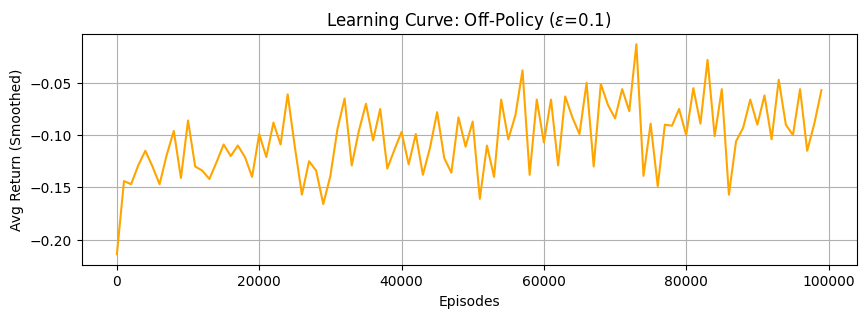

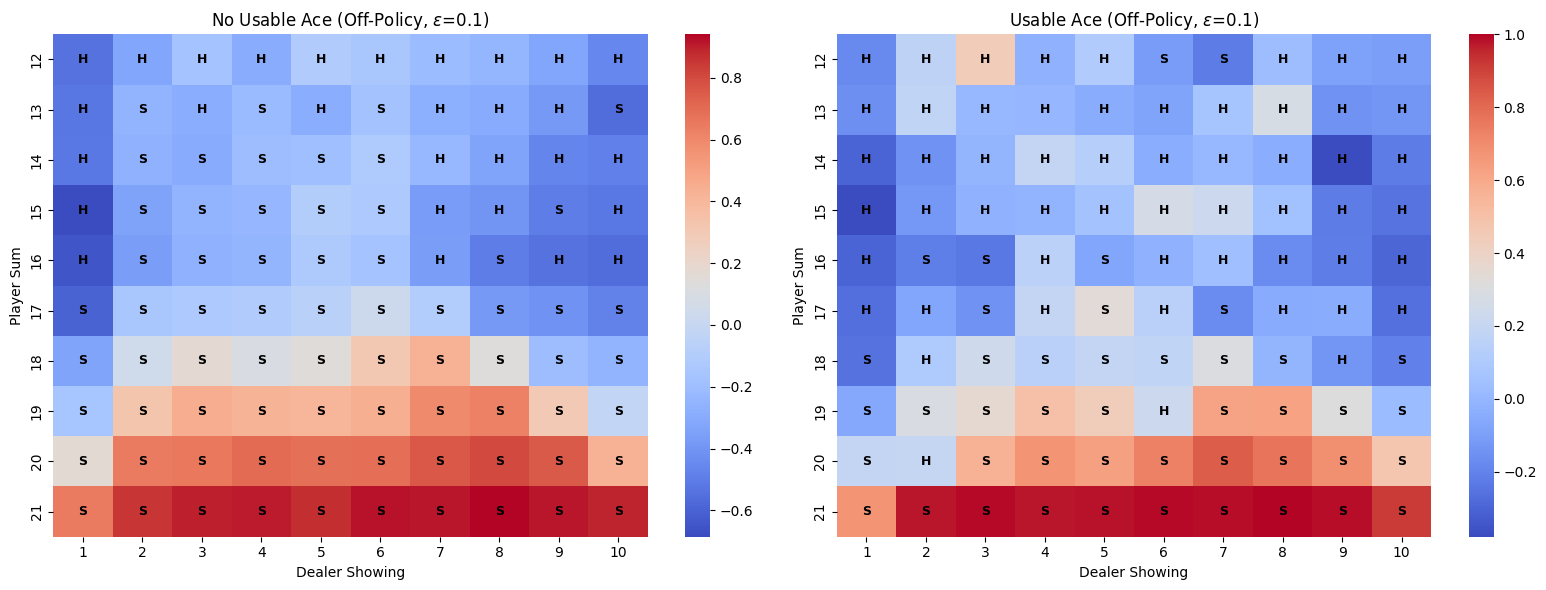

  > Runtime: 69.93s
  > Eval Return: -0.05760
  > Max Importance Weight: 1.23

--- Running Off-Policy MC (epsilon=0.01) ---


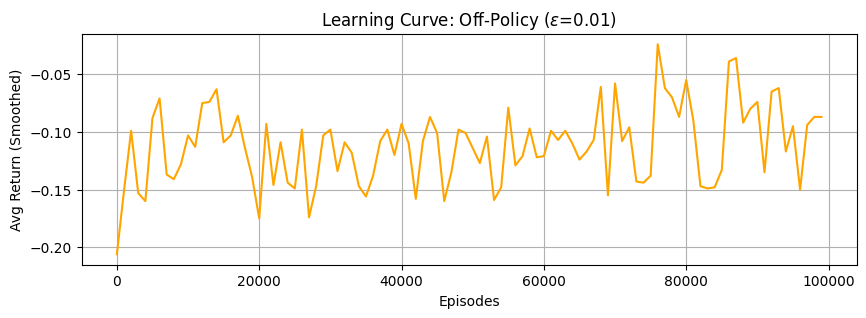

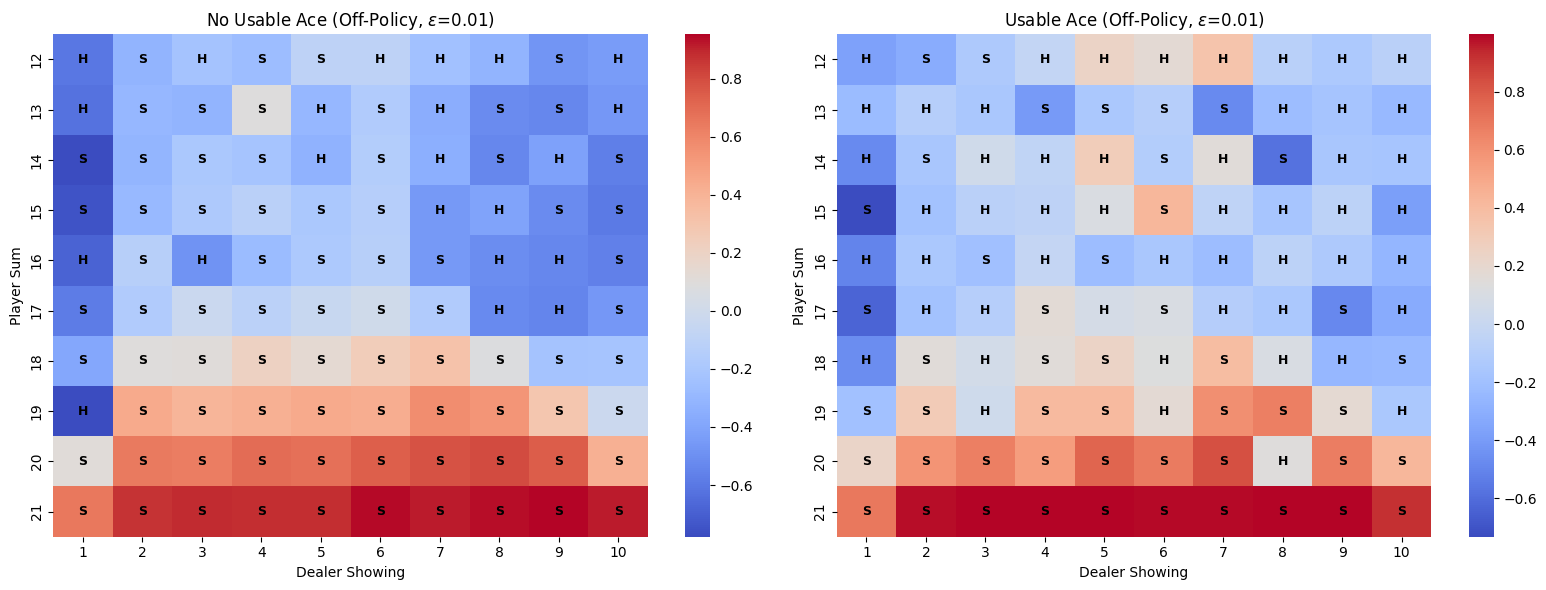

  > Runtime: 84.24s
  > Eval Return: -0.09263
  > Max Importance Weight: 1.02


In [ ]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import time

# --- Helper Functions ---


def get_epsilon_greedy_action(Q, state, epsilon, env):
    """
    Selects an action using an epsilon-soft policy.
    """
    if np.random.random() < epsilon:
        return env.action_space.sample()
    else:
        values = Q[state]
        max_val = np.max(values)
        best_actions = [a for a, v in enumerate(values) if v == max_val]
        return np.random.choice(best_actions)


def get_behavior_prob(Q, state, action, epsilon, n_actions):
    """
    Returns the probability b(a|s) of taking 'action' under the epsilon-soft policy.
    Used for Importance Sampling ratio.
    """
    greedy_action = np.argmax(Q[state])
    if action == greedy_action:
        # Probability of greedy action: 1 - epsilon + (epsilon / |A|)
        return 1.0 - epsilon + (epsilon / n_actions)
    else:
        # Probability of non-greedy action: epsilon / |A|
        return epsilon / n_actions


def evaluate_policy(env, Q, num_episodes=100000):
    wins, losses, draws = 0, 0, 0
    total_return = 0
    for _ in range(num_episodes):
        state, _ = env.reset()
        terminated = False
        while not terminated:
            action = np.argmax(Q[state]) if state in Q else 0
            state, reward, terminated, _, _ = env.step(action)
            if terminated:
                total_return += reward
                if reward > 0:
                    wins += 1
                elif reward < 0:
                    losses += 1
                else:
                    draws += 1
    return total_return / num_episodes, wins/num_episodes, losses/num_episodes, draws/num_episodes

# --- Off-Policy Algorithm with Return Tracking ---


def off_policy_mc_control(env, num_episodes=100000, epsilon=0.1, gamma=1.0):
    start_time = time.time()
    n_actions = env.action_space.n

    Q = defaultdict(lambda: np.zeros(n_actions))
    C = defaultdict(lambda: np.zeros(n_actions))

    # Diagnostics
    weights_history = []
    return_history = []
    running_return = 0
    window_size = 1000

    for i in range(1, num_episodes + 1):
        state, _ = env.reset()
        episode = []
        terminated = False
        truncated = False

        # 1. Generate Episode using Behavior Policy
        while not (terminated or truncated):
            action = get_epsilon_greedy_action(Q, state, epsilon, env)
            next_state, reward, terminated, truncated, _ = env.step(action)
            episode.append((state, action, reward))
            state = next_state

            # Track return for learning curve
            if terminated or truncated:
                running_return += reward

        # 2. Weighted IS Update
        G = 0.0
        W = 1.0

        # Traverse episode backwards
        for t in range(len(episode) - 1, -1, -1):
            s, a, r = episode[t]
            G = gamma * G + r

            C[s][a] += W
            if C[s][a] != 0:
                Q[s][a] += (W / C[s][a]) * (G - Q[s][a])

            greedy_action = np.argmax(Q[s])
            if a != greedy_action:
                W = 0
                break
            else:
                prob_b = get_behavior_prob(Q, s, a, epsilon, n_actions)
                if prob_b > 0:
                    W = W * (1.0 / prob_b)
                else:
                    W = 0

        # Record Diagnostics
        if i % window_size == 0:
            weights_history.append(W)
            return_history.append(running_return / window_size)
            running_return = 0

    execution_time = time.time() - start_time
    return Q, execution_time, weights_history, return_history


# --- Run Experiments Part B ---
print("="*60)
print("PART B: OFF-POLICY MC CONTROL")
print("="*60)

env = gym.make('Blackjack-v1', sab=True)
epsilons = [0.1, 0.01]
results_b = {}

for eps in epsilons:
    print(f"\n--- Running Off-Policy MC (epsilon={eps}) ---")
    Q_off, runtime, w_stats, history = off_policy_mc_control(
        env, num_episodes=100000, epsilon=eps)

    results_b[eps] = {"Q": Q_off, "runtime": runtime, "history": history}

    # 1. Plot Learning Curve
    plt.figure(figsize=(10, 3))
    plt.plot(range(0, 100000, 1000), history, color='orange')
    plt.title(f"Learning Curve: Off-Policy ($\epsilon$={eps})")
    plt.xlabel("Episodes")
    plt.ylabel("Avg Return (Smoothed)")
    plt.grid(True)
    plt.show()

    # 2. Visualize Heatmaps (using the helper defined in previous cells)
    # Ensure plot_blackjack_results is defined from the very first cell of Problem 4
    plot_blackjack_results(Q_off, algorithm_name="Off-Policy", epsilon=eps)

    # 3. Evaluation
    avg_ret, p_win, p_loss, p_draw = evaluate_policy(env, Q_off)
    print(f"  > Runtime: {runtime:.2f}s")
    print(f"  > Eval Return: {avg_ret:.5f}")
    print(
        f"  > Max Importance Weight: {np.max(w_stats) if w_stats else 0:.2f}")

# Part C: Comparison and Analysis

We compare the On-Policy and Off-Policy methods based on:
1.  **Final Evaluation Return:** Does one method find a better policy?
2.  **Runtime:** Which is computationally heavier?

In [14]:
print("="*60)
print("PART C: COMPARISON")
print("="*60)

print(f"{'Metric':<15} | {'Epsilon':<8} | {'On-Policy':<15} | {'Off-Policy':<15}")
print("-" * 60)

for eps in epsilons:
    # Evaluate both stored Q-tables one last time to be sure
    ret_on, _, _, _ = evaluate_policy(
        env, results_a[eps]["Q"], num_episodes=10000)
    ret_off, _, _, _ = evaluate_policy(
        env, results_b[eps]["Q"], num_episodes=10000)

    time_on = results_a[eps]["runtime"]
    time_off = results_b[eps]["runtime"]

    print(f"{'Return':<15} | {eps:<8} | {ret_on:<15.4f} | {ret_off:<15.4f}")
    print(f"{'Runtime (s)':<15} | {eps:<8} | {time_on:<15.2f} | {time_off:<15.2f}")
    print("-" * 60)

PART C: COMPARISON
Metric          | Epsilon  | On-Policy       | Off-Policy     
------------------------------------------------------------
Return          | 0.1      | -0.0649         | -0.0530        
Runtime (s)     | 0.1      | 72.49           | 69.93          
------------------------------------------------------------
Return          | 0.01     | -0.0817         | -0.0891        
Runtime (s)     | 0.01     | 63.86           | 84.24          
------------------------------------------------------------


# Problem 5: SARSA and Q-learning on Stochastic Cliff Walking

## 1. Setup and Helper Functions
In this section, we prepare the environment and visualization tools.

**Environment:**
The assignment requires a **stochastic** version of Cliff Walking ($1/3$ intended, $1/3$ perp-left, $1/3$ perp-right). We implement a helper `make_stochastic_cliff_walking` to modify `CliffWalking-v1` accordingly.

**Visualization:**
We implement two plotting functions to satisfy the requirements:
1.  `plot_cliff_walking`: Displays the Value Function $V(s)$ heatmap with Policy arrows.
2.  `plot_learning_curves`: Plots "Average Return" and "Cliff Falls" side-by-side.

In [21]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time


def make_stochastic_cliff_walking():
    """
    Modifies CliffWalking-v1 to be stochastic (slippery).
    """
    env = gym.make("CliffWalking-v1", render_mode="rgb_array")
    n_actions = env.action_space.n
    n_states = env.observation_space.n
    P = env.unwrapped.P

    # Perpendicular moves mapping (Up, Right, Down, Left)
    perpendicular = {0: [3, 1], 1: [0, 2], 2: [1, 3], 3: [2, 0]}

    # Create new transition table
    new_P = {s: {a: [] for a in range(n_actions)} for s in range(n_states)}

    for s in range(n_states):
        for a in range(n_actions):
            candidates = [a] + perpendicular[a]
            for action_variant in candidates:
                transitions = P[s][action_variant]
                for _, next_s, reward, term in transitions:
                    # Assign 1/3 probability to each variant
                    new_P[s][a].append((1/3.0, next_s, reward, term))
    env.unwrapped.P = new_P
    return env


def plot_cliff_walking(Q, title="Value Function"):
    rows, cols = 4, 12
    V_grid = np.zeros((rows, cols))
    policy_grid = np.empty((rows, cols), dtype=object)
    ARROWS = {0: "↑", 1: "→", 2: "↓", 3: "←"}

    for r in range(rows):
        for c in range(cols):
            s = r * cols + c
            # Cliff: Row 3, Cols 1-10
            if r == 3 and 0 < c < 11:
                policy_grid[r, c] = "CLIFF"
                V_grid[r, c] = -100
                continue
            # Goal: Row 3, Col 11
            if r == 3 and c == 11:
                policy_grid[r, c] = "GOAL"
                V_grid[r, c] = 0
                continue

            V_grid[r, c] = np.max(Q[s])
            policy_grid[r, c] = ARROWS[np.argmax(Q[s])]

    plt.figure(figsize=(12, 4))
    sns.heatmap(V_grid, annot=False, fmt=".1f",
                cmap="viridis", cbar_kws={'label': 'Value'})

    for r in range(rows):
        for c in range(cols):
            text = policy_grid[r, c]
            if text == "CLIFF":
                plt.text(c+0.5, r+0.5, "XX", ha="center",
                         va="center", color="black", fontsize=10)
            elif text == "GOAL":
                plt.text(c+0.5, r+0.5, "G", ha="center",
                         va="center", color="white", weight="bold")
            else:
                plt.text(c+0.5, r+0.5, text, ha="center",
                         va="center", color="white", weight="bold")
    plt.title(title)
    plt.axis("off")
    plt.show()


def plot_learning_curves(history_ret, history_falls, title="Learning Curves"):
    window = 100
    smooth_ret = np.convolve(history_ret, np.ones(window)/window, mode='valid')
    smooth_falls = np.convolve(
        history_falls, np.ones(window)/window, mode='valid')

    fig, ax = plt.subplots(1, 2, figsize=(14, 4))
    ax[0].plot(smooth_ret, color='blue', alpha=0.7)
    ax[0].set_title(f"{title}: Returns")
    ax[0].set_ylabel("Avg Return")

    ax[1].plot(smooth_falls, color='red', alpha=0.7)
    ax[1].set_title(f"{title}: Cliff Falls")
    ax[1].set_ylabel("Avg Falls")
    plt.show()

## Part A: SARSA (On-Policy TD Control)

**Task:**
Implement SARSA with $\epsilon$-greedy exploration and run it for combinations of $\epsilon \in \{0.1, 0.01\}$ and $\alpha \in \{0.1, 0.5\}$.

**Update Rule:**
$$Q(S, A) \leftarrow Q(S, A) + \alpha [R + \gamma Q(S', A') - Q(S, A)]$$
where $A'$ is the action actually chosen by the behavior policy.

**Evaluation:**
After training, evaluate the greedy policy for:
* Average Return & Success Rate
* Cliff Falls
* Average Episode Length

SARSA Runs           | Return   | Succ%   | Falls  | Len   
-----------------------------------------------------------------
e=0.1, a=0.5        | -101.8   | 59.0%   | 0.00   | 101.8 


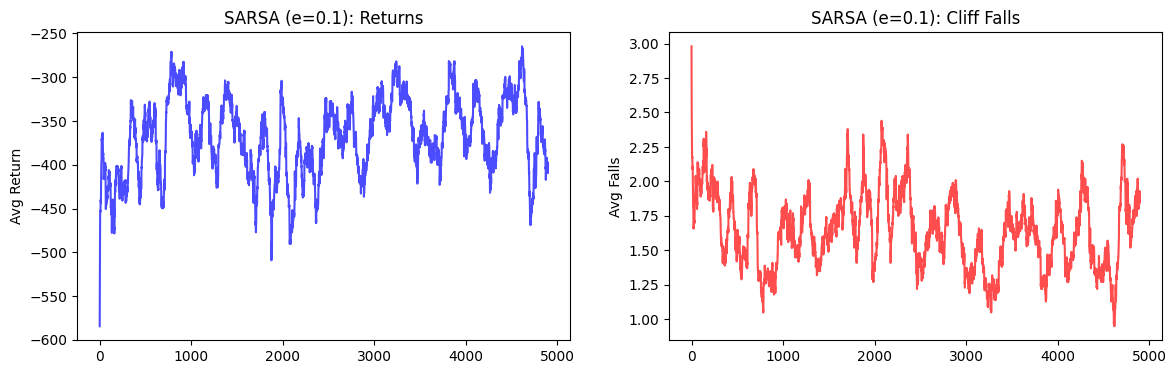

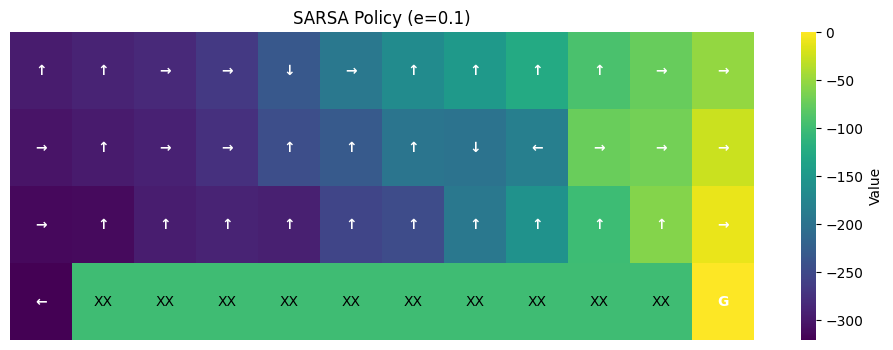

e=0.01, a=0.5        | -193.4   | 23.0%   | 0.00   | 193.4 


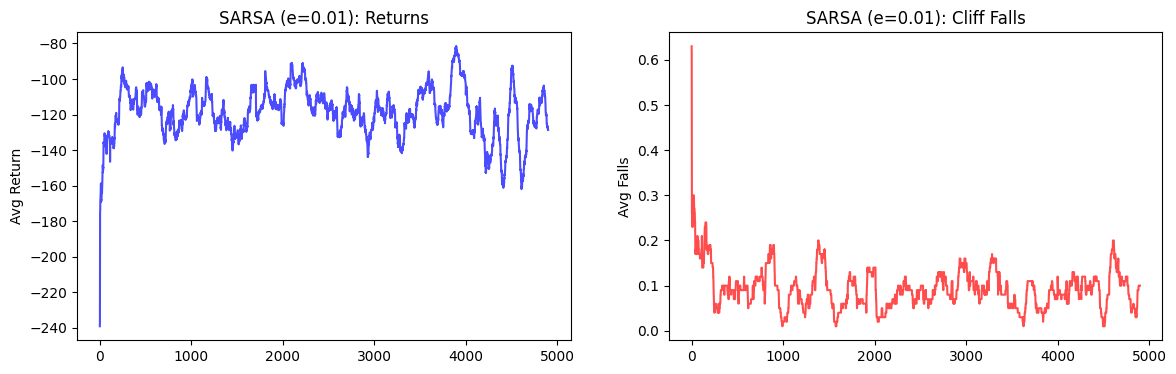

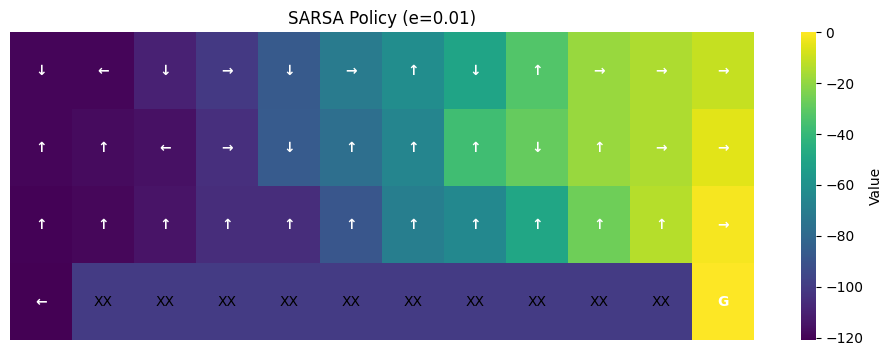

In [22]:
# --- Helper Functions ---
def get_action(Q, state, epsilon, n_actions):
    if np.random.random() < epsilon:
        return np.random.choice(n_actions)
    else:
        values = Q[state]
        max_val = np.max(values)
        candidates = [a for a, v in enumerate(values) if v == max_val]
        return np.random.choice(candidates)


def evaluate_cliff(env, Q, episodes=100):
    success, cliff_falls, total_return, total_len = 0, 0, 0, 0
    for _ in range(episodes):
        state, _ = env.reset()
        terminated = False
        ep_ret, steps = 0, 0
        while not terminated:
            action = np.argmax(Q[state])
            state, reward, terminated, _, _ = env.step(action)
            ep_ret += reward
            steps += 1
            if reward == -100:
                cliff_falls += 1

        total_return += ep_ret
        total_len += steps
        if ep_ret > -100:
            success += 1
    return total_return/episodes, success/episodes, cliff_falls/episodes, total_len/episodes

# --- SARSA Implementation ---


def run_sarsa(env, episodes=5000, alpha=0.5, epsilon=0.1, gamma=1.0):
    n_states = env.observation_space.n
    n_actions = env.action_space.n
    Q = np.zeros((n_states, n_actions))

    hist_ret, hist_falls = [], []
    start_time = time.time()

    for _ in range(episodes):
        state, _ = env.reset()
        action = get_action(Q, state, epsilon, n_actions)
        terminated = False
        total_reward, falls = 0, 0

        while not terminated:
            next_state, reward, terminated, _, _ = env.step(action)
            next_action = get_action(Q, next_state, epsilon, n_actions)

            # SARSA Update
            target = reward + gamma * Q[next_state, next_action]
            Q[state, action] += alpha * (target - Q[state, action])

            state, action = next_state, next_action
            total_reward += reward
            if reward == -100:
                falls += 1

        hist_ret.append(total_reward)
        hist_falls.append(falls)

    return Q, hist_ret, hist_falls, time.time() - start_time


# --- Execution Part A ---
env = make_stochastic_cliff_walking()
params = [{"eps": 0.1, "alpha": 0.5}, {"eps": 0.01, "alpha": 0.5}]

print(f"{'SARSA Runs':<20} | {'Return':<8} | {'Succ%':<7} | {'Falls':<6} | {'Len':<6}")
print("-" * 65)

for p in params:
    eps, alpha = p["eps"], p["alpha"]
    Q_s, h_ret, h_fall, t = run_sarsa(env, 5000, alpha, epsilon=eps)

    # Eval
    ret, succ, fall, length = evaluate_cliff(env, Q_s)
    print(f"e={eps}, a={alpha:<10} | {ret:<8.1f} | {succ:<7.1%} | {fall:<6.2f} | {length:<6.1f}")

    # Visualize
    plot_learning_curves(h_ret, h_fall, title=f"SARSA (e={eps})")
    plot_cliff_walking(Q_s, title=f"SARSA Policy (e={eps})")

## Part B: Q-learning (Off-Policy TD Control)

**Task:**
Implement Q-learning with $\epsilon$-greedy exploration and run it for the same parameters as SARSA.

**Update Rule:**
$$Q(S, A) \leftarrow Q(S, A) + \alpha [R + \gamma \max_{a} Q(S', a) - Q(S, A)]$$
This updates assuming the *optimal* action is taken next, regardless of the actual exploration step.

**Visualization:**
Same as Part A: Value/Policy grid and Learning Curves.

Q-Learning Runs      | Return   | Succ%   | Falls  | Len   
-----------------------------------------------------------------
e=0.1, a=0.5        | -85.2    | 69.0%   | 0.00   | 85.2  


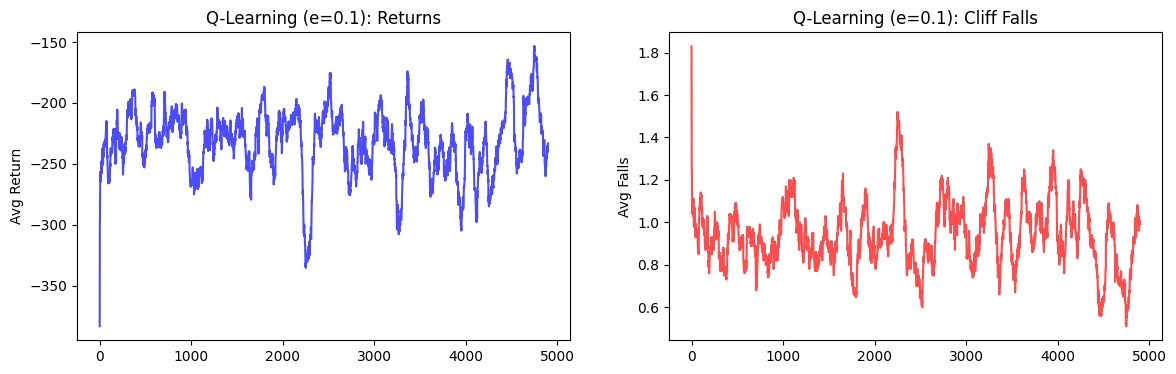

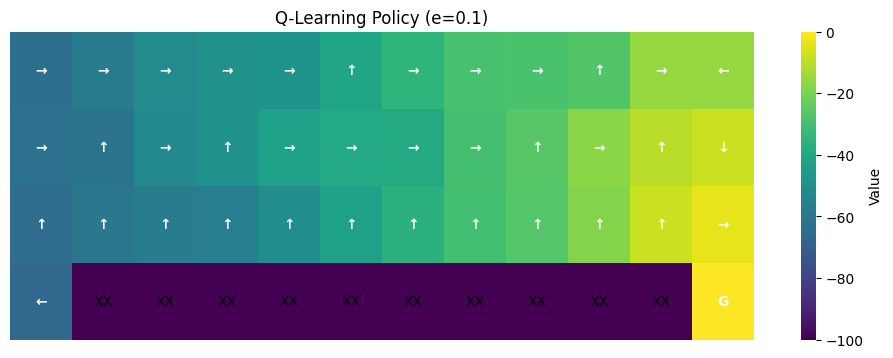

e=0.01, a=0.5        | -78.1    | 79.0%   | 0.00   | 78.1  


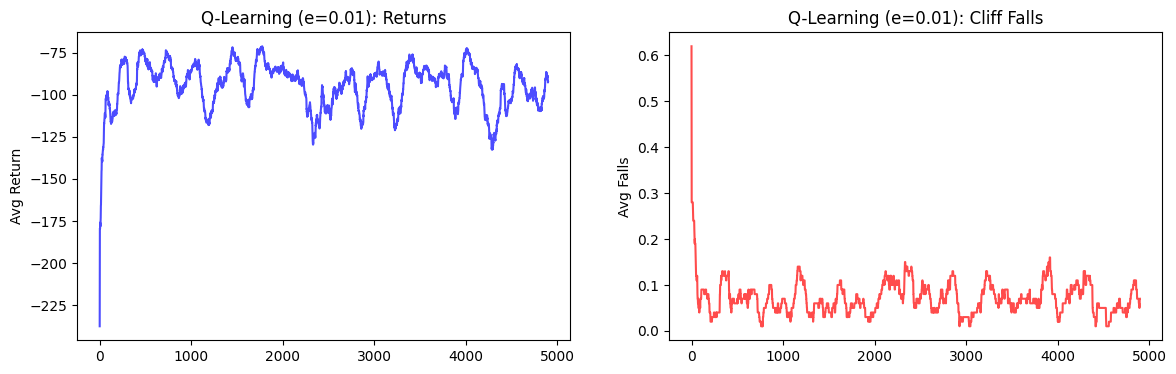

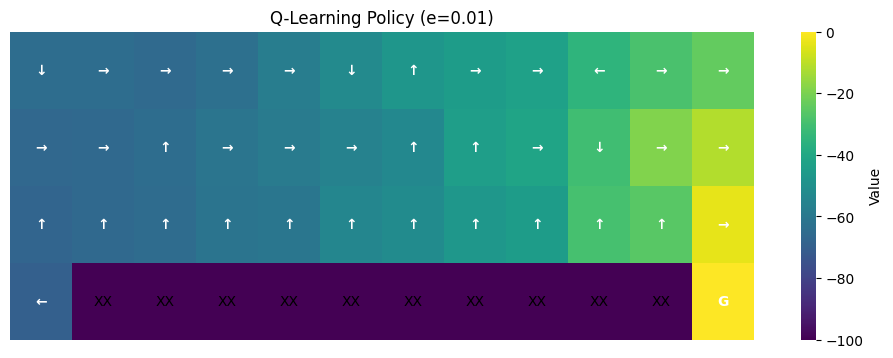

In [23]:
# --- Q-Learning Implementation ---
def run_q_learning(env, episodes=5000, alpha=0.5, epsilon=0.1, gamma=1.0):
    n_states = env.observation_space.n
    n_actions = env.action_space.n
    Q = np.zeros((n_states, n_actions))

    hist_ret, hist_falls = [], []
    start_time = time.time()

    for _ in range(episodes):
        state, _ = env.reset()
        terminated = False
        total_reward, falls = 0, 0

        while not terminated:
            action = get_action(Q, state, epsilon, n_actions)
            next_state, reward, terminated, _, _ = env.step(action)

            # Q-Learning Update
            best_next = np.max(Q[next_state])
            target = reward + gamma * best_next
            Q[state, action] += alpha * (target - Q[state, action])

            state = next_state
            total_reward += reward
            if reward == -100:
                falls += 1

        hist_ret.append(total_reward)
        hist_falls.append(falls)

    return Q, hist_ret, hist_falls, time.time() - start_time


# --- Execution Part B ---
print(f"{'Q-Learning Runs':<20} | {'Return':<8} | {'Succ%':<7} | {'Falls':<6} | {'Len':<6}")
print("-" * 65)

for p in params:
    eps, alpha = p["eps"], p["alpha"]
    Q_q, h_ret, h_fall, t = run_q_learning(env, 5000, alpha, epsilon=eps)

    # Eval
    ret, succ, fall, length = evaluate_cliff(env, Q_q)
    print(f"e={eps}, a={alpha:<10} | {ret:<8.1f} | {succ:<7.1%} | {fall:<6.2f} | {length:<6.1f}")

    # Visualize
    plot_learning_curves(h_ret, h_fall, title=f"Q-Learning (e={eps})")
    plot_cliff_walking(Q_q, title=f"Q-Learning Policy (e={eps})")

## Part C: Comparison and Monte Carlo Discussion

**Task:**
Compare SARSA and Q-learning results, focusing on policy safety vs. risk. Discuss why Monte Carlo methods struggle here.

**Analysis Points:**
1.  **Safety:** SARSA learns a "safer" path (further from the cliff edge) because it accounts for the risk of $\epsilon$-greedy exploration causing a fall. Q-learning learns the optimal (shortest) path right on the edge, ignoring exploration risk.
2.  **Cliff Falls:** During training, SARSA typically experiences fewer falls than Q-learning once the policy starts to converge.
3.  **Monte Carlo Difficulty:** MC methods struggle because they rely on completing an episode to update. In Cliff Walking, random exploration can cause episodes to last indefinitely or end with massive negative returns (-100), leading to high variance and slow learning compared to TD methods which bootstrap (update immediately).

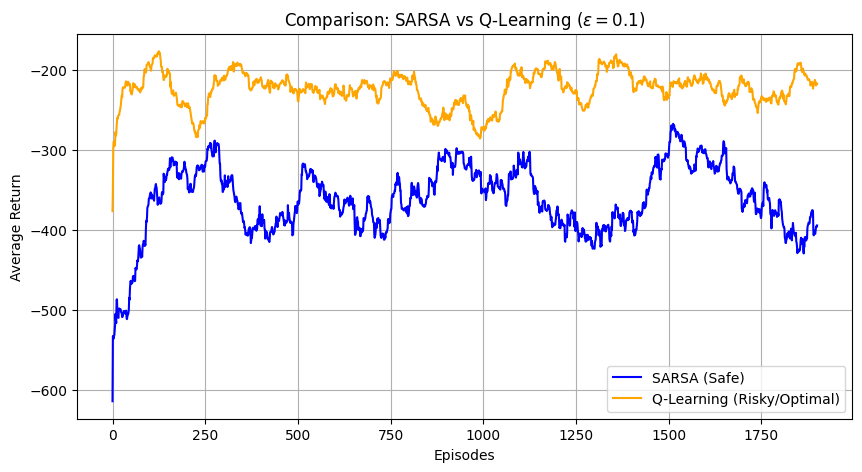

Comparison Complete.


In [24]:
# Comparison of Learning Curves for e=0.1
eps = 0.1
alpha = 0.5

# Re-run single instance to grab history for overlay plot
_, sarsa_ret, _, _ = run_sarsa(env, 2000, alpha, eps)
_, q_ret, _, _ = run_q_learning(env, 2000, alpha, eps)

window = 100
s_smooth = np.convolve(sarsa_ret, np.ones(window)/window, mode='valid')
q_smooth = np.convolve(q_ret, np.ones(window)/window, mode='valid')

plt.figure(figsize=(10, 5))
plt.plot(s_smooth, label="SARSA (Safe)", color='blue')
plt.plot(q_smooth, label="Q-Learning (Risky/Optimal)", color='orange')
plt.title(f"Comparison: SARSA vs Q-Learning ($\epsilon={eps}$)")
plt.xlabel("Episodes")
plt.ylabel("Average Return")
plt.legend()
plt.grid(True)
plt.show()

print("Comparison Complete.")